In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
import seaborn as sns 
from math import pi 
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer, LabelEncoder, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix 

roc_auc_score
df_stru = pd.read_csv("../input/earthquake-magnitude-damage-and-impact/csv_building_structure.csv",
                     index_col = 'building_id')

plt.style.use('ggplot')

In [2]:
print("Structure data has {} rows and {} columns".format(*df_stru.shape))

Structure data has 762106 rows and 30 columns


In [3]:
display(df_stru.dtypes.value_counts())
df_stru.dtypes

int64     20
object    10
dtype: int64

district_id                                int64
vdcmun_id                                  int64
ward_id                                    int64
count_floors_pre_eq                        int64
count_floors_post_eq                       int64
age_building                               int64
plinth_area_sq_ft                          int64
height_ft_pre_eq                           int64
height_ft_post_eq                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_m

In [4]:
df_stru = df_stru.astype({'district_id': 'object', 'vdcmun_id': 'object', 'ward_id': 'object'})

In [5]:
df_temp = df_stru.isnull().sum().reset_index(name='count')
display(df_temp[df_temp['count'] > 0])

df_stru.dropna(inplace = True)

,index,count
14,position,1
15,plan_configuration,1
28,damage_grade,12
29,technical_solution_proposed,12


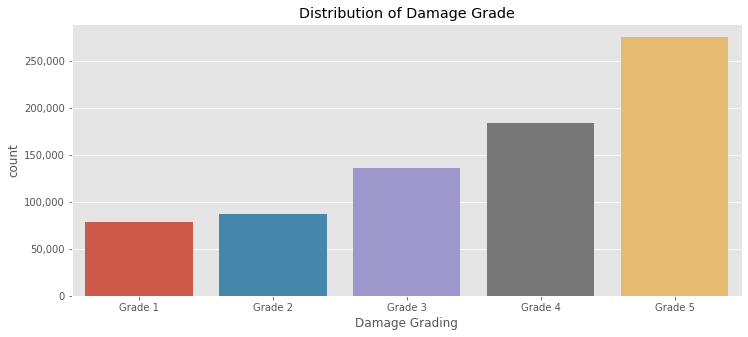

In [6]:
plt.figure(figsize=(12,5))
ax = sns.countplot(x='damage_grade', data=df_stru, order = ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5'])
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.title("Distribution of Damage Grade")
plt.xlabel("Damage Grading")
plt.show()

In [7]:
df_stru.select_dtypes(include=object).dtypes

district_id                    object
vdcmun_id                      object
ward_id                        object
land_surface_condition         object
foundation_type                object
roof_type                      object
ground_floor_type              object
other_floor_type               object
position                       object
plan_configuration             object
condition_post_eq              object
damage_grade                   object
technical_solution_proposed    object
dtype: object

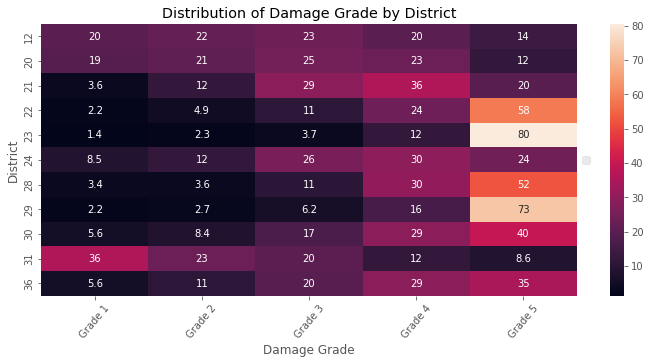

In [8]:
df_temp = df_stru.groupby(['district_id','damage_grade']).size().reset_index(name='count')

df_temp = df_temp.set_index(['district_id', 'damage_grade'])

df_temp = df_temp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

df_temp = pd.pivot_table(df_temp, values='count', index=['district_id'], columns='damage_grade')

plt.figure(figsize=(12,5))
ax = sns.heatmap(data = df_temp, annot = True )
plt.xticks(rotation = 50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by District")
plt.xlabel("Damage Grade")
plt.ylabel("District")
plt.show()

del df_temp, ax

In [9]:
print("vdcmun Wards: {}".format(len(df_stru.vdcmun_id.unique())))
print("Unique Wards: {}".format(len(df_stru.ward_id.unique())))

vdcmun Wards: 110
Unique Wards: 945


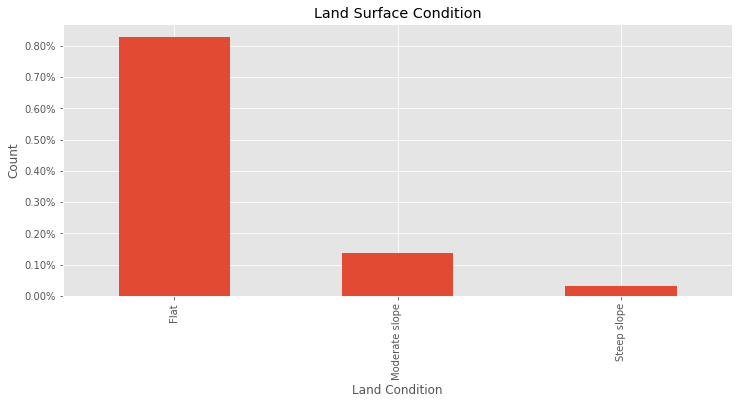

In [10]:
plt.figure(figsize=(12,5))
ax = df_stru.land_surface_condition.value_counts(normalize = True).plot(kind = "bar")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Land Surface Condition")
plt.ylabel("Count")
plt.xlabel("Land Condition")
plt.show()

del ax

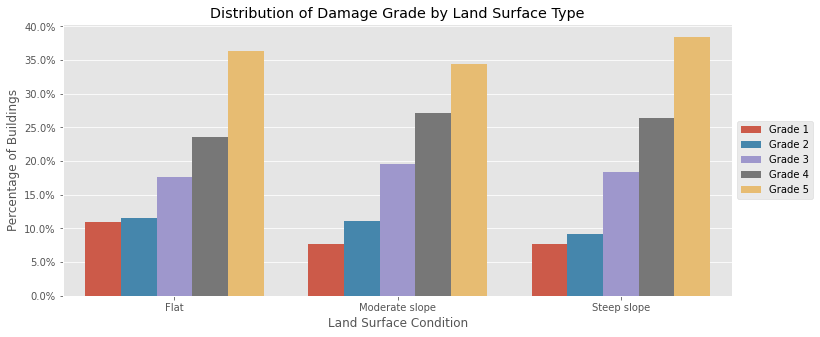

In [11]:
df_temp = df_stru.groupby(['land_surface_condition','damage_grade']).size().reset_index(name='count')

df_temp = df_temp.set_index(['land_surface_condition', 'damage_grade'])

df_temp = df_temp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

plt.figure(figsize=(12,5))
ax = sns.barplot(data = df_temp, 
                 x = 'land_surface_condition', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Land Surface Type")
plt.xlabel("Land Surface Condition")
plt.ylabel("Percentage of Buildings")
plt.show()

del df_temp, ax

In [12]:
df_stru.foundation_type.value_counts()

Mud mortar-Stone/Brick    628705
Bamboo/Timber              57472
Cement-Stone/Brick         39245
RC                         32120
Other                       4552
Name: foundation_type, dtype: int64

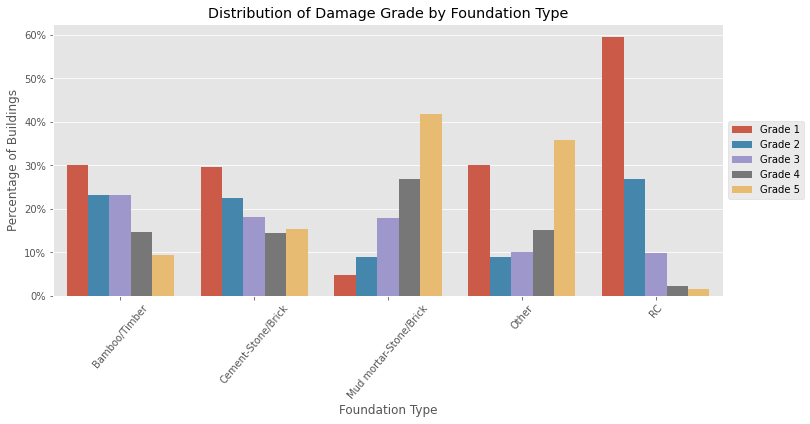

In [13]:
df_temp = df_stru.groupby(['foundation_type','damage_grade']).size().reset_index(name='count')

df_temp = df_temp.set_index(['foundation_type', 'damage_grade'])

df_temp = df_temp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

plt.figure(figsize=(12,5))
ax = sns.barplot(data = df_temp, 
                 x = 'foundation_type', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(rotation = 50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Foundation Type")
plt.xlabel("Foundation Type")
plt.ylabel("Percentage of Buildings")
plt.show()

del df_temp, ax

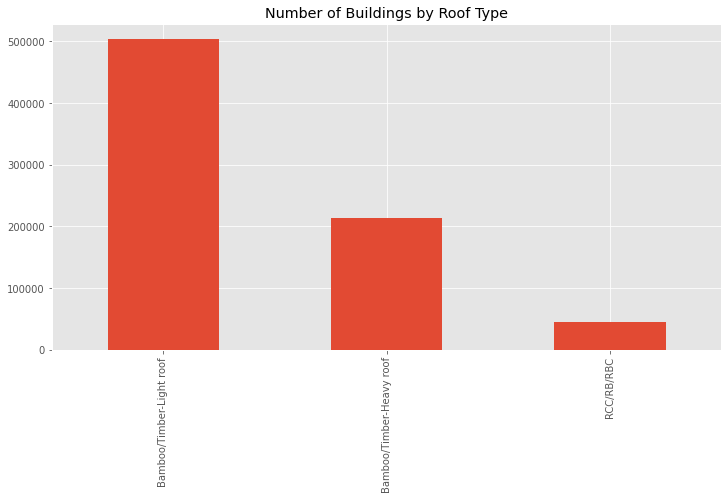

In [14]:
plt.figure(figsize = (12,6))
ax = df_stru.roof_type.value_counts().plot(kind = "bar")
plt.title("Number of Buildings by Roof Type")
plt.show()

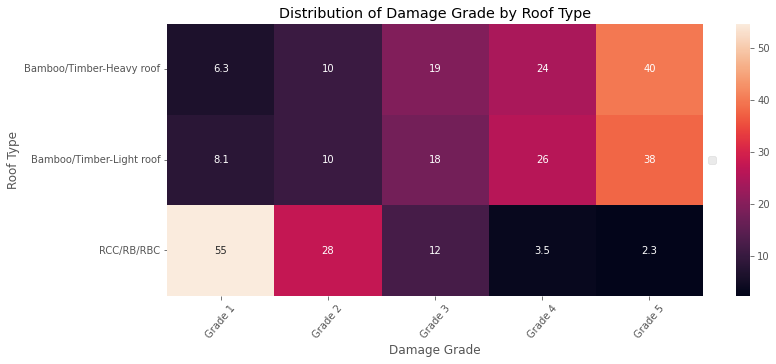

In [15]:
df_temp = df_stru.groupby(['roof_type','damage_grade']).size().reset_index(name='count')

df_temp = df_temp.set_index(['roof_type', 'damage_grade'])

df_temp = df_temp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

df_temp = pd.pivot_table(df_temp, values='count', index=['roof_type'], columns='damage_grade')

plt.figure(figsize=(12,5))
ax = sns.heatmap(data = df_temp, annot = True )
plt.xticks(rotation = 50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Roof Type")
plt.xlabel("Damage Grade")
plt.ylabel("Roof Type")
plt.show()

del df_temp, ax

In [16]:
df_stru.ground_floor_type.value_counts()

Mud            618205
RC              73149
Brick/Stone     66093
Timber           3594
Other            1053
Name: ground_floor_type, dtype: int64

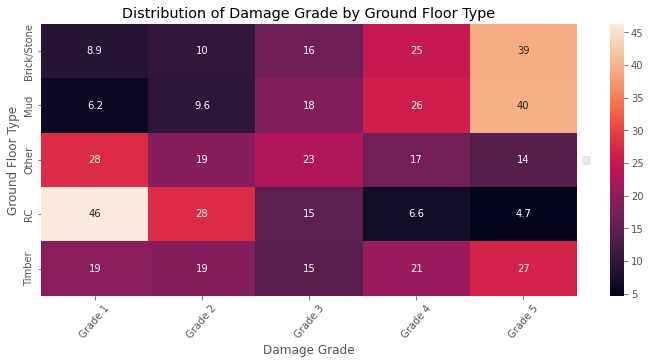

In [17]:
df_temp = df_stru.groupby(['ground_floor_type','damage_grade']).size().reset_index(name='count')

df_temp = df_temp.set_index(['ground_floor_type', 'damage_grade'])

df_temp = df_temp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

df_temp = pd.pivot_table(df_temp, values='count', index=['ground_floor_type'], columns='damage_grade')

plt.figure(figsize=(12,5))
ax = sns.heatmap(data = df_temp, annot = True )
plt.xticks(rotation = 50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Ground Floor Type")
plt.xlabel("Damage Grade")
plt.ylabel("Ground Floor Type")
plt.show()

del df_temp, ax

In [18]:
df_stru.other_floor_type.value_counts(normalize = True)

TImber/Bamboo-Mud    0.638907
Timber-Planck        0.162216
Not applicable       0.155914
RCC/RB/RBC           0.042963
Name: other_floor_type, dtype: float64

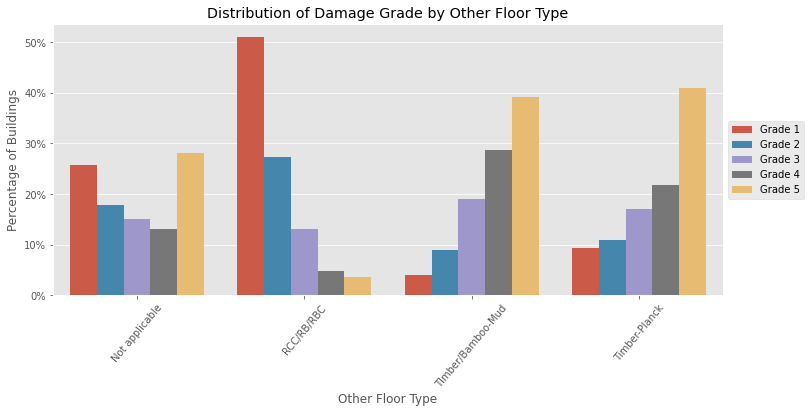

In [19]:
df_temp = df_stru.groupby(['other_floor_type','damage_grade']).size().reset_index(name='count')

df_temp = df_temp.set_index(['other_floor_type', 'damage_grade'])

df_temp = df_temp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

plt.figure(figsize=(12,5))
ax = sns.barplot(data = df_temp, 
                 x = 'other_floor_type', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(rotation = 50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Other Floor Type")
plt.xlabel("Other Floor Type")
plt.ylabel("Percentage of Buildings")
plt.show()

del df_temp, ax

In [20]:
df_stru.position.value_counts(normalize = True)

Not attached       0.793134
Attached-1 side    0.169836
Attached-2 side    0.035311
Attached-3 side    0.001719
Name: position, dtype: float64

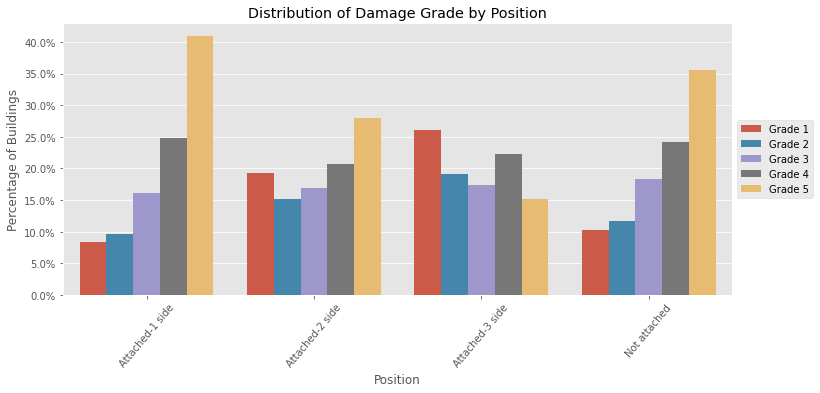

In [21]:
df_temp = df_stru.groupby(['position','damage_grade']).size().reset_index(name='count')

df_temp = df_temp.set_index(['position', 'damage_grade'])

df_temp = df_temp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

plt.figure(figsize=(12,5))
ax = sns.barplot(data = df_temp, 
                 x = 'position', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(rotation = 50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Position")
plt.xlabel("Position")
plt.ylabel("Percentage of Buildings")
plt.show()

del df_temp, ax

In [22]:
df_stru.plan_configuration.value_counts()

Rectangular                        731246
Square                              17576
L-shape                             10079
T-shape                               969
Multi-projected                       940
Others                                518
U-shape                               448
E-shape                               140
Building with Central Courtyard        98
H-shape                                80
Name: plan_configuration, dtype: int64

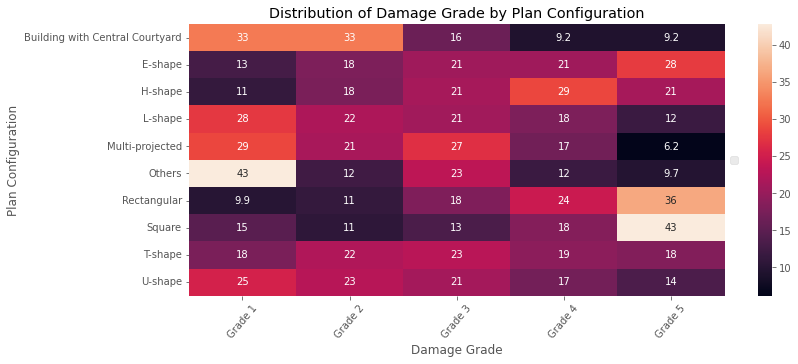

In [23]:
df_temp = df_stru.groupby(['plan_configuration','damage_grade']).size().reset_index(name='count')

df_temp = df_temp.set_index(['plan_configuration', 'damage_grade'])

df_temp = df_temp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

df_temp = pd.pivot_table(df_temp, values='count', index=['plan_configuration'], columns='damage_grade')

plt.figure(figsize=(12,5))
ax = sns.heatmap(data = df_temp, annot = True )
plt.xticks(rotation = 50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Plan Configuration")
plt.xlabel("Damage Grade")
plt.ylabel("Plan Configuration")
plt.show()

del df_temp, ax

In [24]:
df_stru.condition_post_eq.value_counts()

Damaged-Not used                           207968
Damaged-Rubble unclear                     125650
Damaged-Used in risk                       123843
Damaged-Repaired and used                  107791
Damaged-Rubble clear                       102191
Not damaged                                 61139
Damaged-Rubble Clear-New building built     33130
Covered by landslide                          382
Name: condition_post_eq, dtype: int64

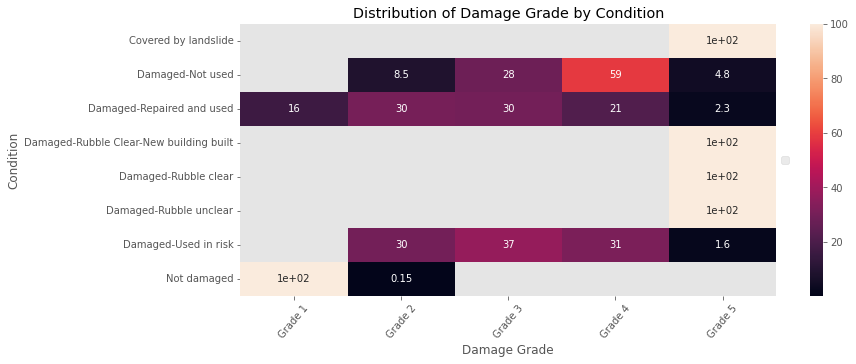

In [25]:
df_temp = df_stru.groupby(['condition_post_eq','damage_grade']).size().reset_index(name='count')

df_temp = df_temp.set_index(['condition_post_eq', 'damage_grade'])

df_temp = df_temp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

df_temp = pd.pivot_table(df_temp, values='count', index=['condition_post_eq'], columns='damage_grade')

plt.figure(figsize=(12,5))
ax = sns.heatmap(data = df_temp, annot = True )
plt.xticks(rotation = 50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Condition")
plt.xlabel("Damage Grade")
plt.ylabel("Condition")
plt.show()

del df_temp, ax

In [26]:
df_stru.technical_solution_proposed.value_counts()

Reconstruction    470219
Major repair      129415
Minor repair      110605
No need            51855
Name: technical_solution_proposed, dtype: int64

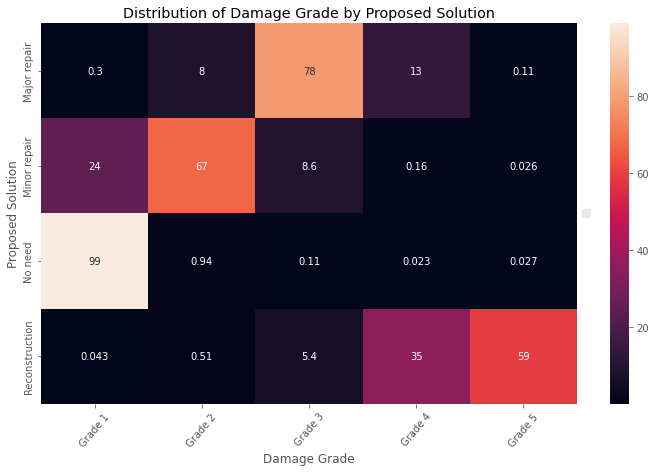

In [27]:
df_temp = df_stru.groupby(['technical_solution_proposed','damage_grade']).size().reset_index(name='count')

df_temp = df_temp.set_index(['technical_solution_proposed', 'damage_grade'])

df_temp = df_temp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

df_temp = pd.pivot_table(df_temp, values='count', index=['technical_solution_proposed'], columns='damage_grade')

plt.figure(figsize=(12,7))
ax = sns.heatmap(data = df_temp, annot = True )
plt.xticks(rotation = 50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Proposed Solution")
plt.xlabel("Damage Grade")
plt.ylabel("Proposed Solution")
plt.show()

del df_temp, ax

In [28]:
df_stru.select_dtypes(include=[float, int]).dtypes 

count_floors_pre_eq                       int64
count_floors_post_eq                      int64
age_building                              int64
plinth_area_sq_ft                         int64
height_ft_pre_eq                          int64
height_ft_post_eq                         int64
has_superstructure_adobe_mud              int64
has_superstructure_mud_mortar_stone       int64
has_superstructure_stone_flag             int64
has_superstructure_cement_mortar_stone    int64
has_superstructure_mud_mortar_brick       int64
has_superstructure_cement_mortar_brick    int64
has_superstructure_timber                 int64
has_superstructure_bamboo                 int64
has_superstructure_rc_non_engineered      int64
has_superstructure_rc_engineered          int64
has_superstructure_other                  int64
dtype: object

In [29]:
df_stru.describe().transpose().drop('count', axis=1)

,mean,std,min,25%,50%,75%,max
count_floors_pre_eq,2.087787,0.655104,1.0,2.0,2.0,2.0,9.0
count_floors_post_eq,1.252050,1.063278,0.0,0.0,1.0,2.0,9.0
age_building,24.325031,65.034555,0.0,9.0,16.0,27.0,999.0
plinth_area_sq_ft,406.673668,226.780437,70.0,280.0,358.0,470.0,5000.0
height_ft_pre_eq,16.049424,5.493900,6.0,12.0,16.0,18.0,99.0
height_ft_post_eq,9.868785,8.574218,0.0,0.0,11.0,16.0,99.0
has_superstructure_adobe_mud,0.042402,0.201504,0.0,0.0,0.0,0.0,1.0
has_superstructure_mud_mortar_stone,0.800269,0.399799,0.0,1.0,1.0,1.0,1.0
has_superstructure_stone_flag,0.035122,0.184087,0.0,0.0,0.0,0.0,1.0
has_superstructure_cement_mortar_stone,0.015816,0.124762,0.0,0.0,0.0,0.0,1.0


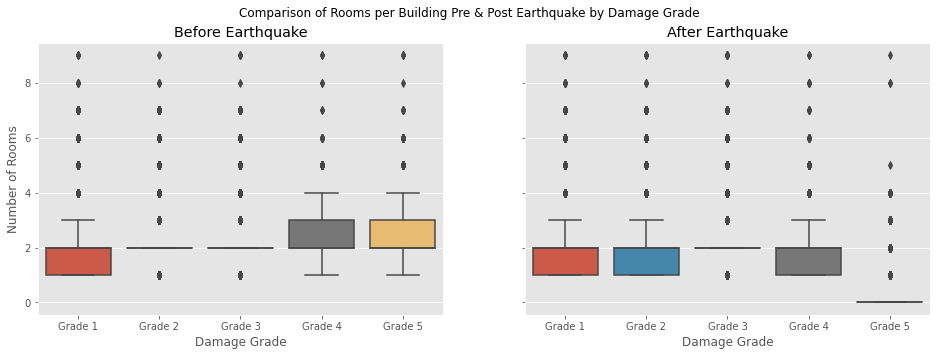

In [30]:
fig, ax = plt.subplots(1,2,figsize = (16,5), sharey='row')
fig.suptitle("Comparison of Rooms per Building Pre & Post Earthquake by Damage Grade")
ax[0].set_title("Before Earthquake")
ax[1].set_title("After Earthquake")
sns.boxplot(data = df_stru, 
            x = "damage_grade", 
            y = "count_floors_pre_eq", 
            order = ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5'],
            ax = ax[0])
sns.boxplot(data = df_stru, 
            x = "damage_grade", 
            y = "count_floors_post_eq", 
            order = ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5'],
            ax = ax[1])
plt.setp(ax[:], xlabel='Damage Grade')
plt.setp(ax[0], ylabel='Number of Rooms')
plt.setp(ax[1], ylabel=None)
plt.show()

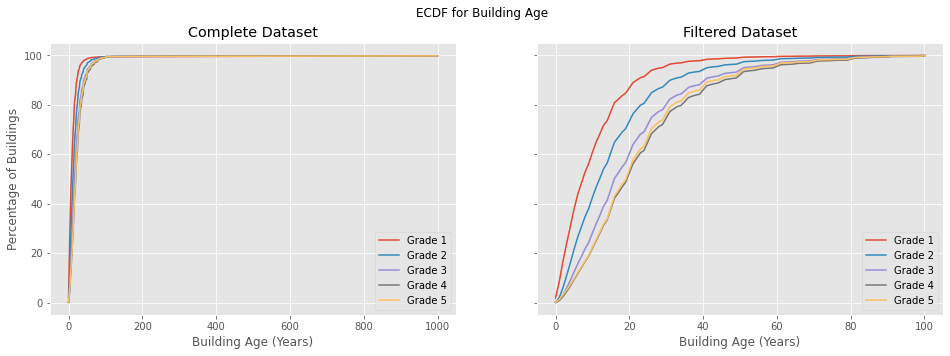

In [31]:
def ecdf(series):
    ''' This function calculates the ECDF for a series of real numbers'''
    
    n = len(series)
    
    x = np.sort(series)
    
    y = np.arange(1, n+ 1) / n * 100
    
    return pd.DataFrame({'x':x, 'y':y})
v_grades = ['Grade ' + str(x) for x in range(1,6)]

fig, ax = plt.subplots(1,2, figsize = (16,5), sharey='row')
fig.suptitle("ECDF for Building Age")
ax[0].set_title("Complete Dataset")
ax[1].set_title("Filtered Dataset")

for grade in v_grades:
    df_temp = df_stru[df_stru.damage_grade == grade] # filter for grade only 
    df_temp = ecdf(df_temp.age_building) # Compute ecdf for grade
    sns.lineplot(data = df_temp, x = 'x', y = 'y', label = grade, ax = ax[0]) # Generate line plot
    del df_temp

for grade in v_grades:
    df_temp = df_stru[(df_stru.damage_grade == grade) & (df_stru.age_building <= 100)] # filter
    df_temp = ecdf(df_temp.age_building) # Compute ecdf for grade
    sns.lineplot(data = df_temp, x = 'x', y = 'y', label = grade, ax = ax[1]) # Generate line plot
    del df_temp

plt.setp(ax[:], xlabel='Building Age (Years)')
plt.setp(ax[0], ylabel='Percentage of Buildings')
plt.setp(ax[1], ylabel=None)
plt.show()

del grade, v_grades, fig, ax

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


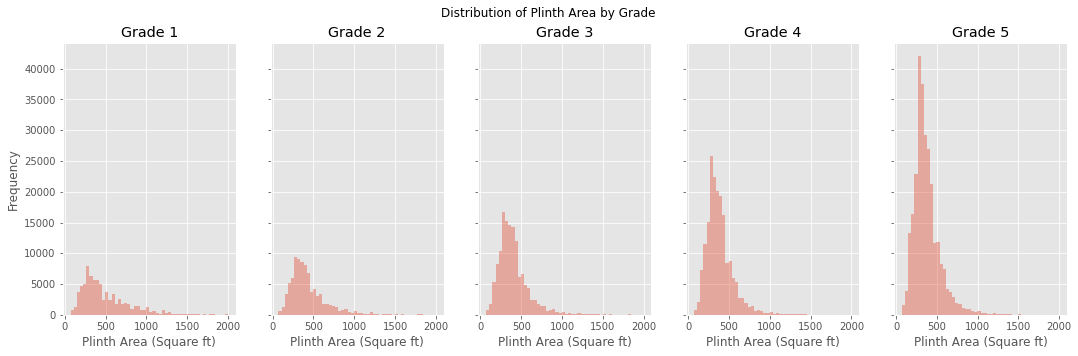

In [32]:
v_grades = ['Grade ' + str(x) for x in range(1,6)]

fig, ax = plt.subplots(1, 5, figsize=(18,5), sharey="row", sharex="row")
fig.suptitle("Distribution of Plinth Area by Grade")

count = 0
for grade in v_grades:
    df_temp = df_stru[(df_stru.damage_grade == grade) & (df_stru.plinth_area_sq_ft <= 2000)] # filter for grade
    ax[count].set_title(grade)
    sns.distplot(a = df_temp['plinth_area_sq_ft'], label = grade, kde=False, ax=ax[count])
    del df_temp
    count += 1
    
plt.setp(ax[:], xlabel='Plinth Area (Square ft)')
plt.setp(ax[0], ylabel='Frequency')
plt.show()

del grade, v_grades, fig, ax, count

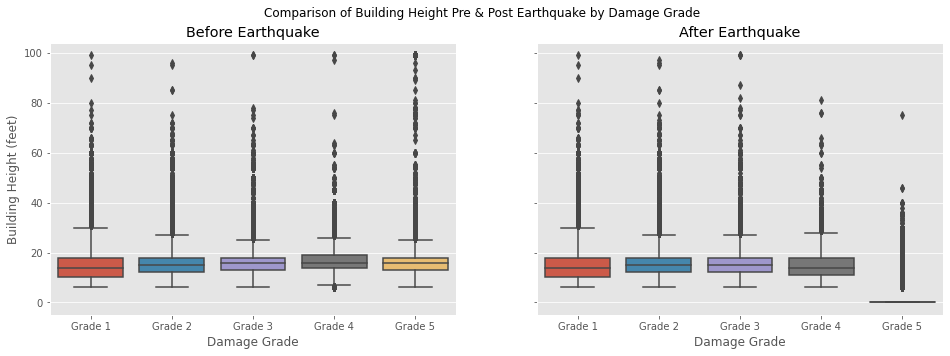

In [33]:
fig, ax = plt.subplots(1,2,figsize = (16,5), sharey='row')
fig.suptitle("Comparison of Building Height Pre & Post Earthquake by Damage Grade")
ax[0].set_title("Before Earthquake")
ax[1].set_title("After Earthquake")
sns.boxplot(data = df_stru, 
            x = "damage_grade", 
            y = "height_ft_pre_eq", 
            order = ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5'],
            ax = ax[0])
sns.boxplot(data = df_stru, 
            x = "damage_grade", 
            y = "height_ft_post_eq", 
            order = ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5'],
            ax = ax[1])
plt.setp(ax[:], xlabel='Damage Grade')
plt.setp(ax[0], ylabel='Building Height (feet)')
plt.setp(ax[1], ylabel=None)
plt.show()

del fig, ax

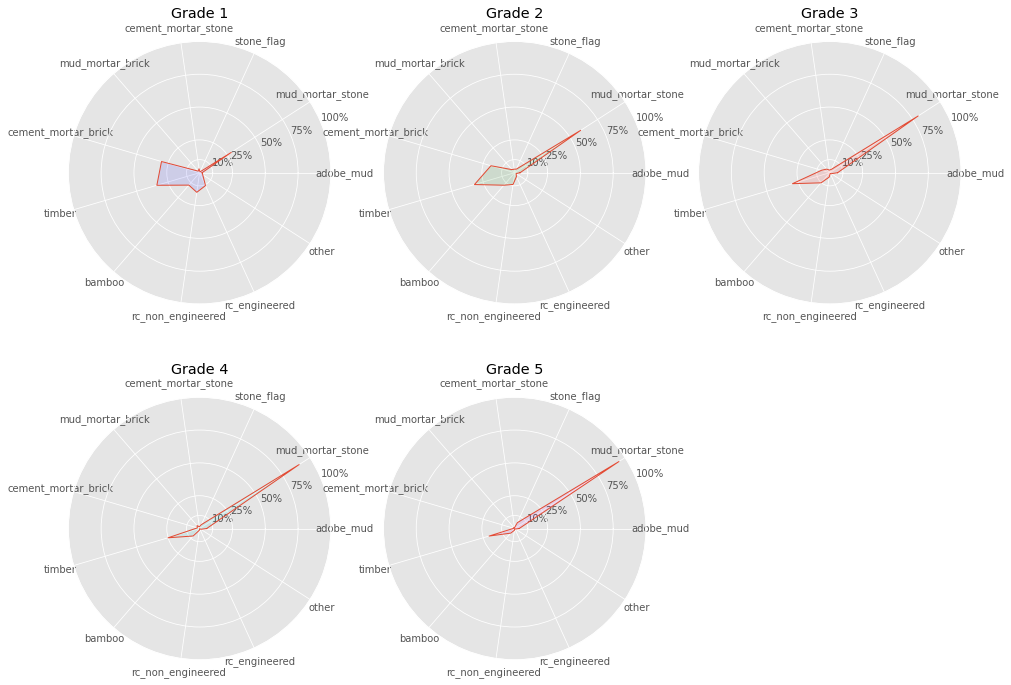

In [34]:
v_cols = ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
          'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone',
          'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 
          'has_superstructure_timber', 'has_superstructure_bamboo', 
          'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 
          'has_superstructure_other']

v_names = {'has_superstructure_adobe_mud':'adobe_mud', 
           'has_superstructure_mud_mortar_stone':'mud_mortar_stone',
          'has_superstructure_stone_flag':'stone_flag', 
           'has_superstructure_cement_mortar_stone':'cement_mortar_stone',
          'has_superstructure_mud_mortar_brick':'mud_mortar_brick', 
           'has_superstructure_cement_mortar_brick':'cement_mortar_brick', 
          'has_superstructure_timber':'timber', 
           'has_superstructure_bamboo':'bamboo', 
          'has_superstructure_rc_non_engineered':'rc_non_engineered', 
           'has_superstructure_rc_engineered':'rc_engineered', 
          'has_superstructure_other':'other'}

df_temp = df_stru.groupby('damage_grade')[v_cols].agg('mean').reset_index()
df_temp.rename(columns=v_names, inplace = True)

v_grades = ['Grade ' + str(x) for x in range(1,6)]
v_colour = ['b', 'g', 'r', 'c', 'm']

v_categories = list(df_temp)[1:]
v_N = len(v_categories)

v_angles = [n / float(v_N) * 2 * pi for n in range(v_N)]
v_angles += v_angles[:1]

fig, ax = plt.subplots(2,3, figsize = (16,12), subplot_kw=dict(polar=True))

plt.setp(ax, 
         xticks = v_angles[:-1], 
         xticklabels = v_categories,
         yticks = [0.10,0.25,0.50,0.75,1.0],
         yticklabels = ["10%","25%","50%","75%","100%"],
         ylim = (0,1))

count, row, col = 0, 0, 0
for grade in v_grades:   
    values = df_temp.loc[count].drop('damage_grade').values.flatten().tolist()
    values += values[:1]
    ax[row, col].plot(v_angles, values, linewidth=1, linestyle='solid', label=grade)
    ax[row, col].fill(v_angles, values, v_colour[count], alpha=0.1)
    ax[row, col].set_title(grade)

    if count >= 2: 
        row = 1
    
    if col < 2: 
        col += 1
    else:
        col = 0
    
    count += 1 

fig.delaxes(ax[1,2])

del v_cols, v_names, df_temp, v_grades, v_colour,\
    v_categories, v_N, v_angles, fig, ax, count, row, col, grade

In [35]:
df_stru['net_rooms'] = df_stru.count_floors_post_eq - df_stru.count_floors_pre_eq
df_stru['net_height'] = df_stru.height_ft_post_eq - df_stru.height_ft_pre_eq

In [36]:
x_train, x_test, y_train, y_test = train_test_split(df_stru.drop('damage_grade', axis = 1), 
                                                    df_stru['damage_grade'],
                                                    test_size = 0.2, 
                                                    random_state = 1989, 
                                                    stratify = df_stru['damage_grade'],
                                                    shuffle=True)


pd.merge(y_train.reset_index(name="damage_grade").damage_grade.value_counts(normalize = True).reset_index(name="train"),
         y_test.reset_index(name="damage_grade").damage_grade.value_counts(normalize = True).reset_index(name="test"),
         on = "index",
         how = "left")

,index,train,test
0,Grade 5,0.361853,0.361851
1,Grade 4,0.241235,0.241236
2,Grade 3,0.178995,0.179000
3,Grade 2,0.114497,0.114494
4,Grade 1,0.103419,0.103419


In [37]:
preprocessor_tar = LabelEncoder()
y_train = preprocessor_tar.fit_transform(y_train)
y_test = preprocessor_tar.fit_transform(y_test)

pd.DataFrame(y_train).value_counts(normalize = True)

del preprocessor_tar

In [38]:
print("Before preprocessing there were {} rows and {} columns".format(*x_train.shape))

fts_cvt_obj = ['district_id', 'vdcmun_id', 'ward_id']
fts_outlier = ['age_building']
fts_cat = df_stru.drop(fts_cvt_obj, axis = 1).select_dtypes(include=['object']).drop('damage_grade', axis = 1).columns
fts_num = df_stru.select_dtypes(np.number).columns

def covert_to_object(x):
    '''Converts a column to object'''
    return pd.DataFrame(x).astype(object)
trans_to_object = Pipeline(steps = [('convert_to_object', FunctionTransformer(covert_to_object))])

trans_outlier = Pipeline(steps = [('Outlier_scaler', RobustScaler(quantile_range = (0,0.9)))])

trans_cat = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])

trans_num = Pipeline(steps = [('scaler', StandardScaler()),
                              ('MinMax', MinMaxScaler())])

trans_nzv = Pipeline(steps = [('nzv', VarianceThreshold(threshold = 0.01))])

preprocessor_preds = ColumnTransformer(
    transformers=[
        ('convert_to_object', trans_to_object, fts_cvt_obj),
        ('Outlier', trans_outlier, fts_outlier),
        ('num', trans_num, fts_num), 
        ('cat', trans_cat, fts_cat),
        ('nzv', trans_nzv,[]) 
    ])
      
x_train = preprocessor_preds.fit_transform(x_train)
x_test = preprocessor_preds.fit_transform(x_test)   

print("After preprocessing there are {} rows and {} columns".format(*x_train.shape))

del fts_cvt_obj, fts_outlier, fts_cat, fts_num, covert_to_object, trans_to_object, trans_outlier, trans_cat, trans_num, trans_nzv

Before preprocessing there were 609675 rows and 31 columns
After preprocessing there are 609675 rows and 69 columns


In [39]:
kfold = KFold(n_splits=5, random_state=1989, shuffle = True)